# Projet : Segmenter des clients d'un site de e-commerce : Notebook de modélisation

In [1]:
## Importation des librairies nécessaires
import pandas as pd
import numpy as np

In [2]:
## Importation des librairies supplémentaires utiles
%matplotlib inline
import os
from time import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import homogeneity_score, adjusted_rand_score, adjusted_mutual_info_score, silhouette_score
from sklearn import metrics
from sklearn.preprocessing import normalize
from sklearn.cluster import MeanShift, estimate_bandwidth
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, InterclusterDistance
from sklearn.cluster import KMeans

In [3]:
import warnings
mpl.rcParams["figure.figsize"] = (12, 8)
init_notebook_mode()
warnings.filterwarnings('ignore')

In [4]:
pip install yellowbrick

In [5]:
## Chargement des données de base pour les modèles d'essais : Nous construsons les premiers modèles d'essai à l'aide des features RFM

data = pd.read_csv("rfm.csv", sep=",")

In [6]:
data.head()

customer_unique_id  Recency  Frequency  Monetary
0  0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
1  0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
2  0000f46a3911fa3c0805444483337064      536          1     86.22
3  0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62
4  0004aac84e0df4da2b147fca70cf8255      287          1    196.89

In [7]:
# Utilisons 'customer_unique_id' comme index

data.set_index("customer_unique_id", inplace=True)

# Segmentation des clients avec les kmeans

In [8]:
# 1. Normalisation des données

scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

In [9]:
# 2. Choix du nombre optimal de clusters (méthode du coude et du score de silhouette)

inertias = []
silhouettes = []
seed = 111
K = range(2, 10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, random_state=seed)
    kmeanModel.fit(data_normalized)
    inertias.append(kmeanModel.inertia_)
    silhouettes.append(silhouette_score(data_normalized, kmeanModel.labels_))

  File "C:\Users\tykap\anaconda3\envs\myenv\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


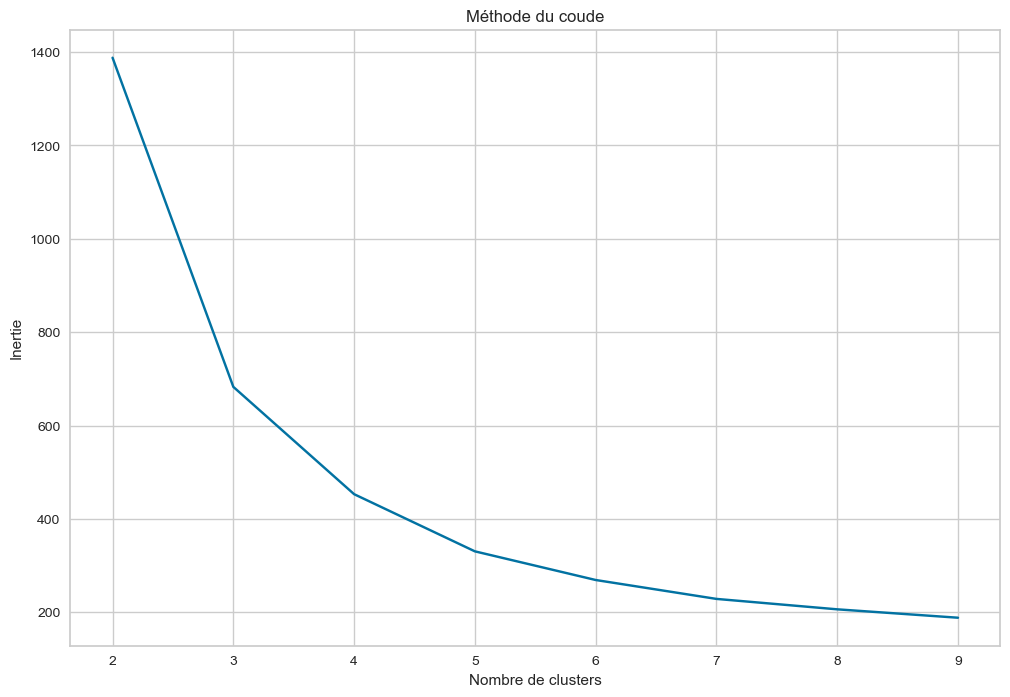

In [10]:
## a. Tracer la courbe de l'inertie en fonction du nombre de clusters
plt.plot(range(2, 10), inertias)
plt.xlabel('Nombre de clusters')
plt.ylabel('Inertie')
plt.title('Méthode du coude')
plt.show()

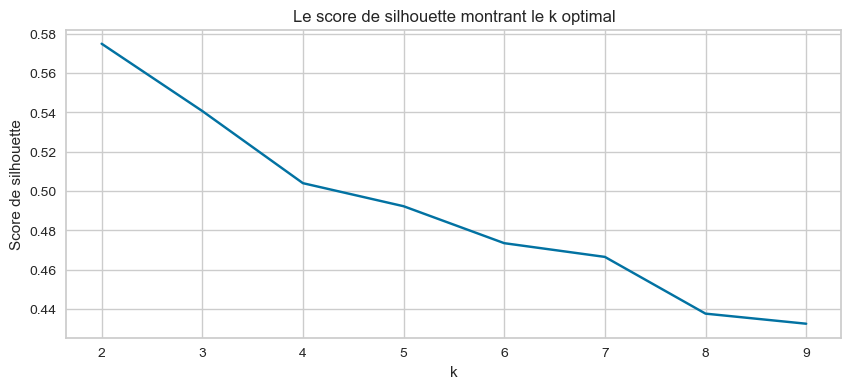

In [11]:
## b. Graphique du score de silhouette

plt.figure(figsize=(10,4))
plt.plot(K, silhouettes, 'bx-')
plt.xlabel('k')
plt.ylabel('Score de silhouette')
plt.title('Le score de silhouette montrant le k optimal')
plt.show()

In [12]:
# 3. Appliquer KMeans avec le nombre de clusters optimal trouvé (4 ici )
kmeans = KMeans(n_clusters=4, random_state=seed)
kmeans.fit(data_normalized)

KMeans(n_clusters=4, random_state=111)

In [13]:
# 4. Ajouter les labels de cluster au DataFrame
data['cluster_label'] = kmeans.labels_
data

Recency  Frequency  Monetary  cluster_label
customer_unique_id                                                           
0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90              2
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19              2
0000f46a3911fa3c0805444483337064      536          1     86.22              1
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62              3
0004aac84e0df4da2b147fca70cf8255      287          1    196.89              3
...                                   ...        ...       ...            ...
fffcf5a5ff07b0908bd4e2dbc735a684      446          2   2067.42              1
fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58              3
ffff371b4d645b6ecea244b27531430a      567          1    112.46              1
ffff5962728ec6157033ef9805bacc48      118          1    133.69              2
ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56              1

[93358 rows x 4 columns]

In [14]:
# Nombre de client par cluster

data["cluster_label"].value_counts()

cluster_label
0    27081
2    25396
3    24274
1    16607
Name: count, dtype: int64

Nous constatons que chaque cluster contient un nombre assez conséquent de clients le minimum étant de 16607 pour le cluster 1

In [15]:
# Interprétation des groupes
# Afficher les statistiques des clusters
cluster_stats = data.groupby('cluster_label')[data.columns].mean()
cluster_stats

Recency  Frequency    Monetary  cluster_label
cluster_label                                                  
0              182.797829   1.071785  150.268375            0.0
1              482.547901   1.062865  154.105147            1.0
2               61.339699   1.080682  159.170138            2.0
3              313.034770   1.074195  154.047119            3.0

In [16]:
cluster_labels = kmeans.labels_

In [17]:
# Calculer le score de silhouette
silhouette_avg = silhouette_score(data_normalized, cluster_labels)
print("Score de silhouette :", silhouette_avg)

Score de silhouette : 0.5039889840777901


# Analyse / Interprétation des différents clusters

Nous avons en tout 4 groupes de clients :
- Le groupe 0 : Ce sont les clients dont le panier moyen est le moins élevé autour de 150 Reals. Ils ne sont réguliers, leur dernier achat remonte à environ 6 mois. ==> Clients à réactiver
- Le groupe 1 : Ce sont les clients dont leur dernier achat remonte à plus d'un an, ils ont un panier moyen autour 154 Reals. ==> Clients perdus 
- Le groupe 2 : Ce sont les clients les plus fidèles, leur dernier achat remonte à 2 mois, ils ont un panier moyen le plus élevé autour de 159 Reals. ==> Clients fidèles à fort capacité d'achat.
- Le groupe 3 : Ce sont les clients ayant un panier moyen à 154 Reals, leur dernier achat remonte à plus de 10 mois. ==> Clients à risque 

NB: Avec les paramètres RFM, la segmentation reste très général et limitée pour apporter une compréhension précise des besoins des clients et proposer des solutions pertinentes et adéquates. Il est nécessaires d'obtenir plusieurs autres variables explicatives afin d'affnier notre analyse.

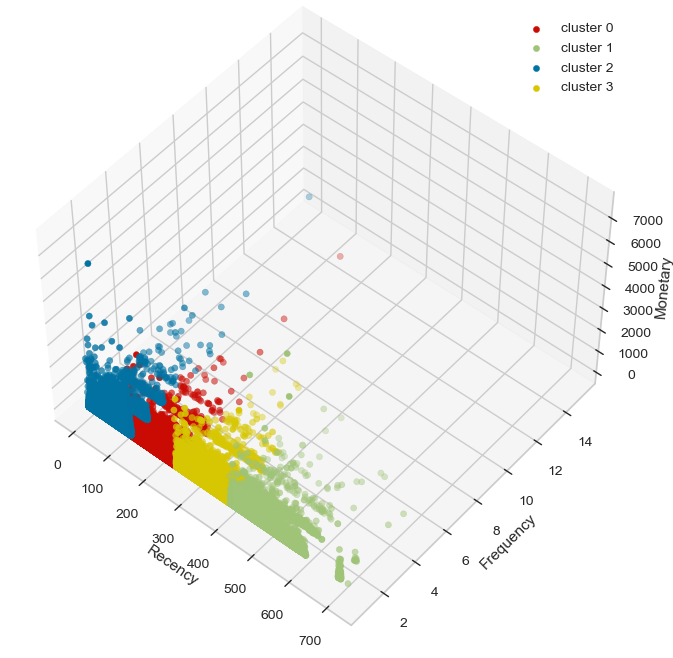

In [18]:
# Visualisation 3D des différents clusters


from mpl_toolkits.mplot3d import Axes3D

# Créer une figure 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Couleurs pour chaque segment (vous pouvez ajuster cela selon vos préférences)
colors = {0: 'r', 1: 'g', 2: 'b', 3: 'y'}

# Ajouter chaque segment à la visualisation
for cluster, cluster_data in data.groupby('cluster_label'):
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'cluster {cluster}', c=colors[cluster])

# Ajouter des labels aux axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Ajouter une légende
ax.legend()

# Rotation du graphique (ajustez les angles selon les besoins)
ax.view_init(elev=50, azim=-50)

# Afficher le graphique
plt.show()

In [19]:
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

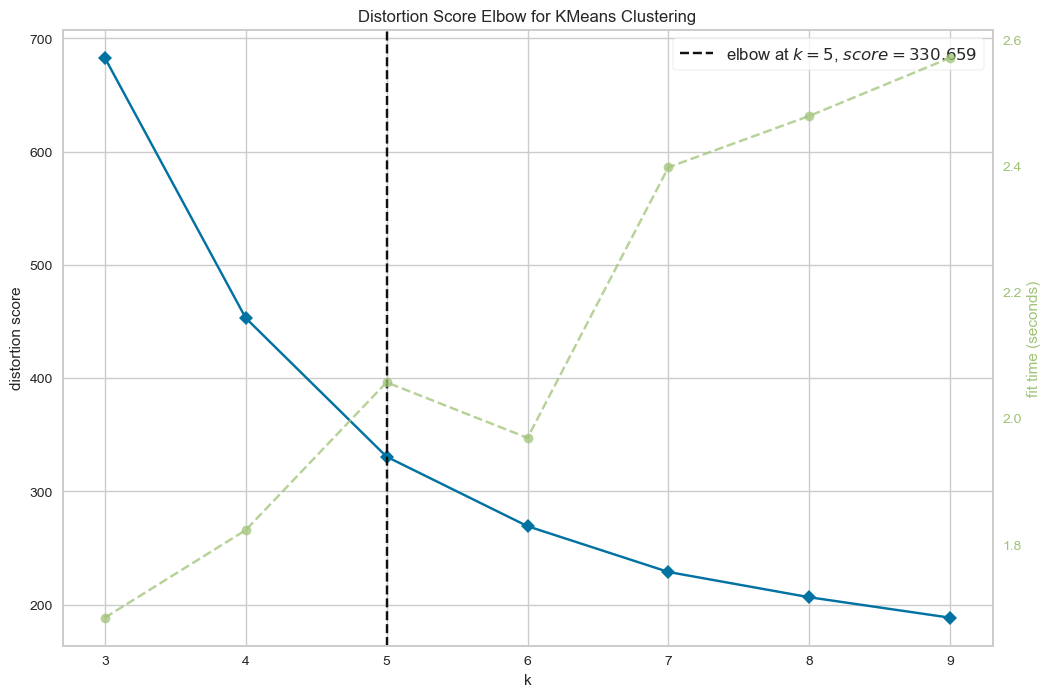

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,10))

visualizer.fit(data_normalized)    # Adaptation des données au visualiseur
visualizer.poof()    # Affichage

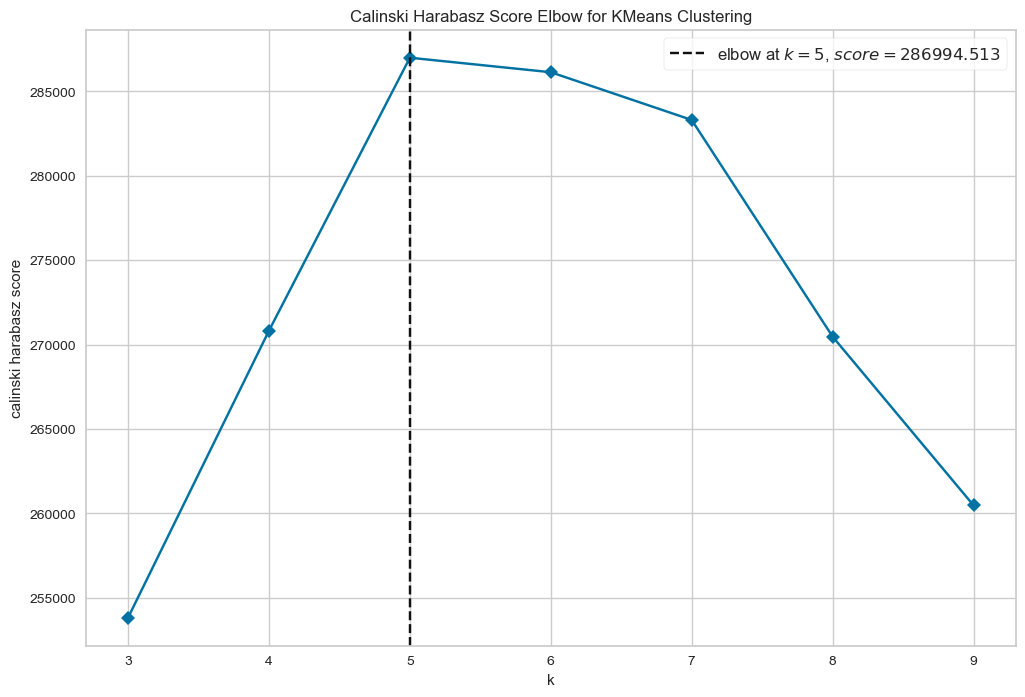

<Axes: title={'center': 'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [21]:
visualizer = KElbowVisualizer(model, k=(3,10), metric='calinski_harabasz', timings=False)

visualizer.fit(data_normalized)    # Fit the data to the visualizer
visualizer.poof()  

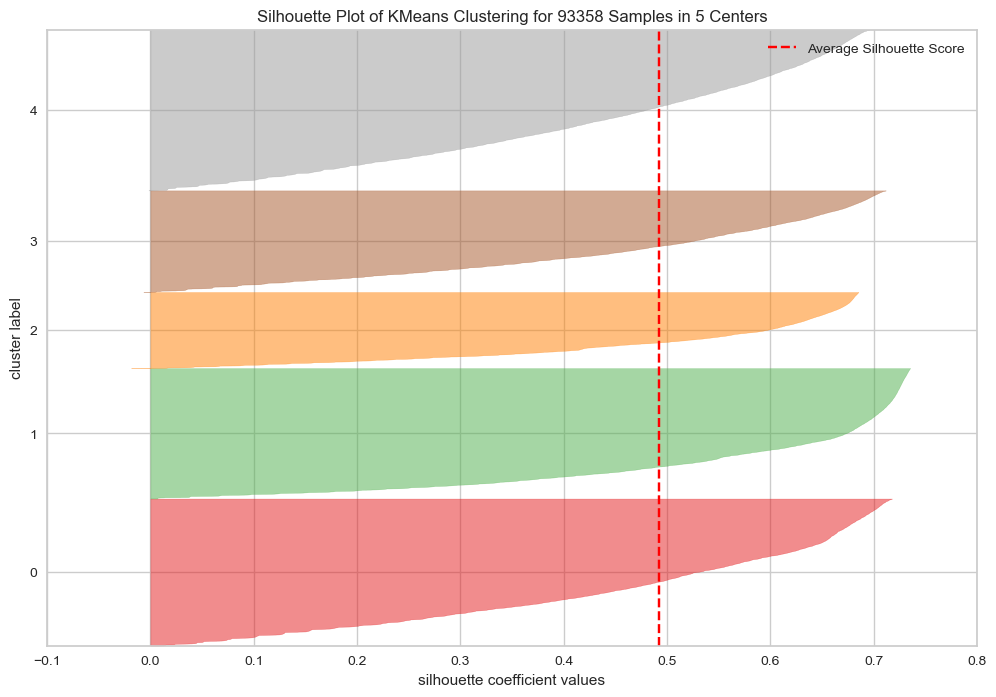

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [22]:
model = KMeans(5)
visualizer = SilhouetteVisualizer(model)

visualizer.fit(data_normalized)    
visualizer.poof() 

# Segmentation des client via la CAH (Classification Hiérarchique Ascendante)

# Présentation de l'approche
La Classification Ascendante Hiérarchique (CAH) est une méthode d'analyse de regroupement (clustering) qui vise à regrouper des individus ou des objets en fonction de leurs similarités ou dissimilarités.

Cette méthode est dite "ascendante" car elle construit une hiérarchie de regroupements à partir de la fusion successive des individus ou des groupes les plus similaires.

La construction de la CAH implique les étapes suivantes :

- Étape 1 : Définir la mesure de similarité ou dissimilarité appropriée pour les données (distance euclienne, Manhattan, corrélation etc.)
- Étape 2 : Calculer la matrice de similarité ou dissimilarité entre les individus ou groupes.
- Étape 3 : Initialiser chaque individu ou groupe comme un cluster isolé.
- Étape 4 : Calculer les similarités ou dissimilarités entre tous les clusters.
- Étape 5 : Fusionner les deux clusters les plus similaires (ou les moins dissimilaires) pour former un nouveau cluster.
- Étape 6 : Mettre à jour la matrice de similarité ou dissimilarité en tenant compte du nouveau cluster formé.
- Étape 7 : Répéter les étapes 4 à 6 jusqu'à ce que tous les individus soient regroupés en un seul cluster.
- Étape 8 : Visualiser les résultats à l'aide d'un dendrogramme pour interpréter la structure des regroupements.

In [23]:
# 1. Construction de la matrice des distances

from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

In [24]:
data = data.drop(columns=['cluster_label'], axis=1)
data

Recency  Frequency  Monetary
customer_unique_id                                            
0000366f3b9a7992bf8c76cfdf3221e2      111          1    141.90
0000b849f77a49e4a4ce2b2a4ca5be3f      114          1     27.19
0000f46a3911fa3c0805444483337064      536          1     86.22
0000f6ccb0745a6a4b88665a16c9f078      320          1     43.62
0004aac84e0df4da2b147fca70cf8255      287          1    196.89
...                                   ...        ...       ...
fffcf5a5ff07b0908bd4e2dbc735a684      446          2   2067.42
fffea47cd6d3cc0a88bd621562a9d061      261          1     84.58
ffff371b4d645b6ecea244b27531430a      567          1    112.46
ffff5962728ec6157033ef9805bacc48      118          1    133.69
ffffd2657e2aad2907e67c3e9daecbeb      483          1     71.56

[93358 rows x 3 columns]

In [25]:
data_normalized = pd.DataFrame(scaler.fit_transform(data), index=data.index, columns=data.columns)
data_normalized.head()

Recency  Frequency  Monetary
customer_unique_id                                             
0000366f3b9a7992bf8c76cfdf3221e2  0.155680        0.0  0.017497
0000b849f77a49e4a4ce2b2a4ca5be3f  0.159888        0.0  0.002327
0000f46a3911fa3c0805444483337064  0.751753        0.0  0.010134
0000f6ccb0745a6a4b88665a16c9f078  0.448808        0.0  0.004500
0004aac84e0df4da2b147fca70cf8255  0.402525        0.0  0.024768

'''Chaque client étant considéré via la méthode CAH comme le centre d'un groupe, le nombre de clients (plus de 93000) semble être un frein pour l'application
de cette méthode. Nous allons réduire la taille des données en réalisant un échantilonnage afin de mettre en oeuvre la segmentation sur cet échantillon via CAH.'''

In [26]:
# Réalisons un echantillonnage afn de réduire la taille (échantillon réalisé sur la fréquence)

NewData = data.sample(n=10000, weights='Frequency', random_state=42)
NewData.shape

(10000, 3)

In [27]:
# Normalisons les données de cet échantillon

NewData_normalized = pd.DataFrame(scaler.fit_transform(NewData), index=NewData.index, columns=NewData.columns)
NewData_normalized.head()

Recency  Frequency  Monetary
customer_unique_id                                             
5fa5c678f4d4461d97eaa1eb5be92c8f  0.306916        0.0  0.039625
f3389293cc0b443733c08a58740dbdba  0.083573        0.0  0.013759
bb315046ce367f23b45ecfc8a89a5abc  0.221902        0.0  0.054250
9953a17fee8d42408513cbb2b66f2bc2  0.170029        0.0  0.022777
27ef96372042804a66039f87fcb7aa92  0.231988        0.0  0.012912

In [28]:
# Calcul de la matrice de similarité/dissimilarité
linkage_matrix = linkage(NewData_normalized, method='ward', metric='euclidean')#Ward : Cette méthode minimise la somme des carrés des écarts au sein des clusters.
                                                                        #Elle tente de trouver des regroupements compacts et homogènes en minimisant la variance globale.

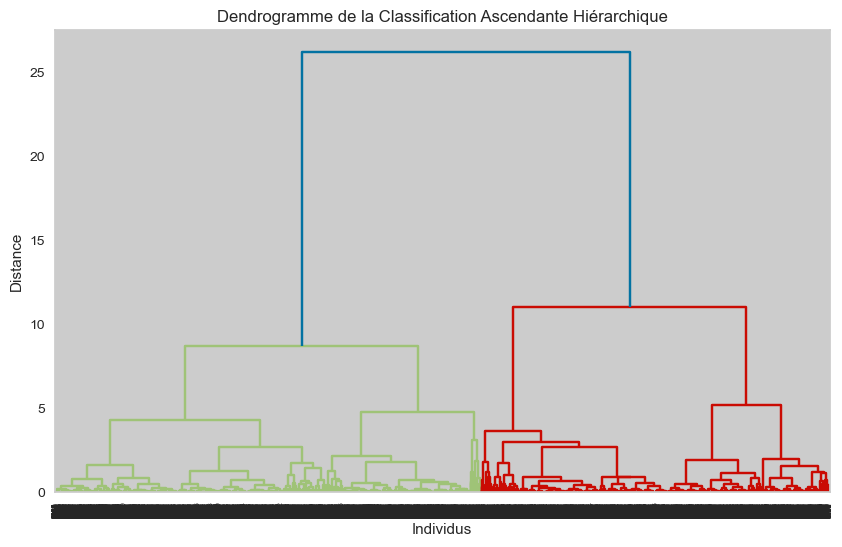

In [29]:
# 2.Construction du dendogramme
'''Méthode du saut maximum : Observez les distances verticales entre les fusions de clusters dans le dendrogramme. 
Recherchez les sauts les plus importants et identifiez le niveau de similarité/dissimilarité correspondant. 
Le nombre de clusters peut être déterminé par le nombre de sauts significatifs dans le dendrogramme.'''

# Affichage du dendrogramme
plt.figure(figsize=(10, 6))
dendrogram(linkage_matrix)
plt.title('Dendrogramme de la Classification Ascendante Hiérarchique')
plt.xlabel('Individus')
plt.ylabel('Distance')
plt.show()

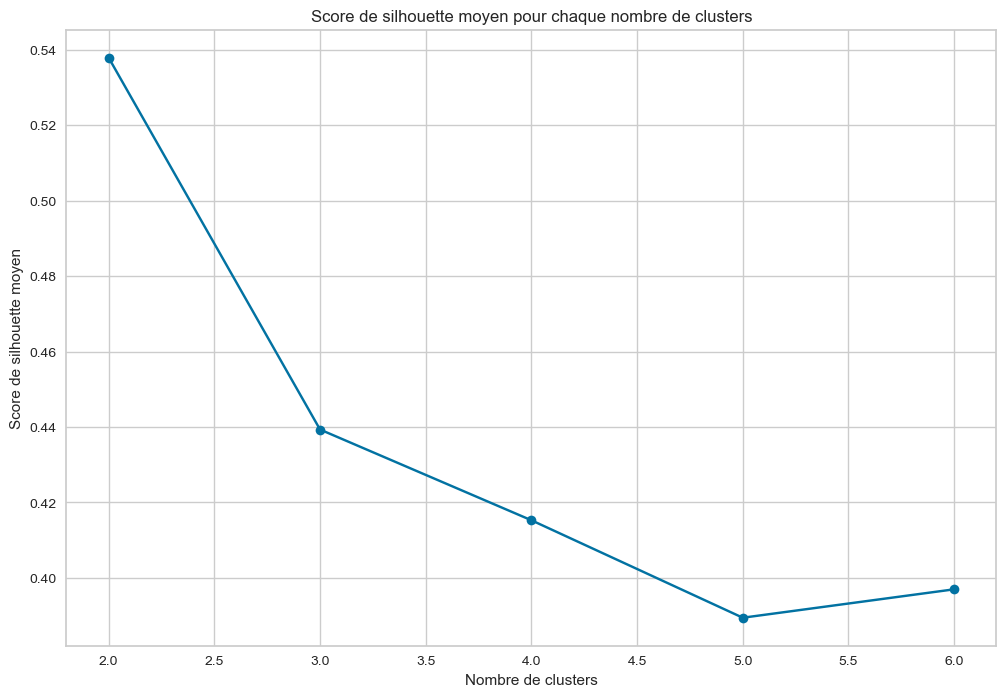

Nombre optimal de clusters : 2


In [30]:
# Effectuer la CAH avec différentes coupes du dendrogramme
max_clusters = 6  # Nombre maximal de clusters à considérer
silhouette_scores = []

for num_clusters in range(2, max_clusters+1):
    clusters = fcluster(linkage(NewData_normalized, method='ward', metric='euclidean'), num_clusters, criterion='maxclust')
    silhouette_avg = silhouette_score(NewData_normalized, clusters)
    silhouette_scores.append(silhouette_avg)

# Tracer le graphique du score de silhouette moyen pour chaque nombre de clusters
plt.plot(range(2, max_clusters+1), silhouette_scores, marker='o')
plt.title("Score de silhouette moyen pour chaque nombre de clusters")
plt.xlabel("Nombre de clusters")
plt.ylabel("Score de silhouette moyen")
plt.show()

# Trouver le nombre optimal de clusters qui maximise le score de silhouette moyen
optimal_num_clusters = np.argmax(silhouette_scores) + 2  # +2 car on commence à 2 clusters
print("Nombre optimal de clusters :", optimal_num_clusters)

In [31]:
# Choisir 2 clusters nous semble pas très pertinent. Avec 3 clusters, nous n'avons pas le niveau de détail souhaité par Olist.

# Nous retenons le nombre de clusters à 4 clusters
num_clusters = 4

# Effectuer la CAH avec le nombre de clusters choisi
clusters = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# Ajouter les informations de cluster dans le DataFrame
NewData['Cluster'] = clusters

# Afficher les statistiques des clusters
cluster_stats = NewData.groupby('Cluster').mean()
cluster_stats

Recency  Frequency    Monetary
Cluster                                   
1        165.622965   1.149100  130.923239
2         46.791252   1.213221  200.156377
3        305.382500   1.210833  183.467788
4        466.816004   1.076665  125.998831

In [32]:
# Nombre de client par cluster

NewData["Cluster"].value_counts()

Cluster
1    3501
3    2400
4    2087
2    2012
Name: count, dtype: int64

Etant donné que nous soyons obligés de segmenter qu'un échantillon, nous n'allons pas nous attarder sur l'analyse de ce clustering. Nous n'allons non plus retenir la segmentation via CAH pour le modèle final à construire.

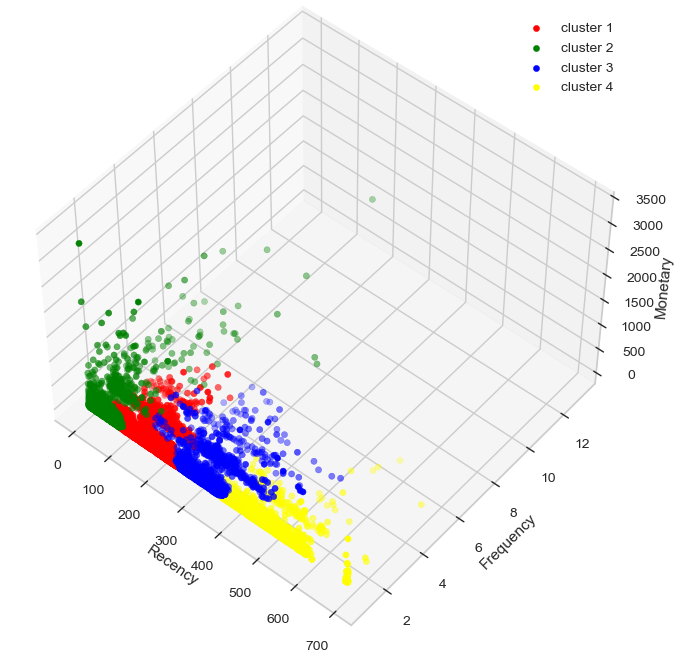

In [33]:
# Visualisation 3D des différents clusters

# Créer une figure 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Couleurs pour chaque segment
colors = {1: 'red', 2: 'green', 3: 'blue', 4:'yellow'}

# Ajouter chaque segment à la visualisation
for cluster, cluster_data in NewData.groupby('Cluster'):
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'cluster {cluster}', c=colors[cluster])

# Ajouter des labels aux axes
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Ajouter une légende
ax.legend()

# Rotation du graphique 
ax.view_init(elev=50, azim=-50)

# Afficher le graphique
plt.show()

# Segmentation des client via DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

Qu'est-ce que DBSCAN ?

DBSCAN signifie "Density-Based Spatial Clustering of Applications with Noise". C'est un algorithme de clustering basé sur la densité, qui peut identifier des clusters de formes variées dans un ensemble de données.

Comment fonctionne DBSCAN ?
DBSCAN fonctionne sur deux principaux concepts :

- Épsilon (ε) : Il s'agit de la distance maximale entre deux points pour qu'ils soient considérés comme dans le même voisinage.

- Minimum Points (MinPts) : Le nombre minimum de points nécessaires pour former un cluster dense.

Le processus de DBSCAN peut être résumé en quatre étapes :

1. Pour chaque point dans l'ensemble de données, DBSCAN forme une région de voisinage de rayon ε autour du point.
2. Si un point a au moins MinPts dans sa région de voisinage, alors ce point est considéré comme un point central (core point).
3. Les points qui sont à moins de ε du point central sont considérés comme faisant partie du même cluster.
4. Les points qui ne sont pas dans le voisinage de ε d'un point central sont considérés comme des bruits (noise points).

Avantages de DBSCAN:
- Peut découvrir des clusters de formes arbitraires.
- Pas besoin de spécifier le nombre de clusters.
- Robuste aux outliers.

Limitations de DBSCAN:
- Ne fonctionne pas bien lorsque la densité varie à travers les clusters.
- Sensible aux paramètres ε et MinPts.

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
import gc 

In [35]:
# Instancer un modèle DBSCAN

dbscan_model = DBSCAN()

# Définir les hyperparamètres à tester avec GridSearchCV
param_grid = {'eps': [0.1, 0.2, 0.3],
             'min_samples': [60, 70, 80]}

# Recherche des meilleurs hyperparamètres avec GridSearchCV
grid_search = GridSearchCV(dbscan_model, param_grid, scoring=silhouette_score, cv=3)

# Enregistrement du temps actuel
start_time = time()

grid_search.fit(NewData_normalized)


# Obtenir les meilleurs hyperparamètres
best_eps = grid_search.best_params_['eps']
best_min_samples = grid_search.best_params_['min_samples']
print(best_eps)
print(best_min_samples)

# Entraîner le modèle avec les meilleurs hyperparamètres
dbscan_model_best = DBSCAN(eps=best_eps, min_samples=best_min_samples).fit(NewData_normalized)

# Calcul du temps d'exécution
elapsed_time = time() - start_time
print(f"Temps d'exécution : {elapsed_time:.2f} secondes")


0.1
60
Temps d'exécution : 36.60 secondes


In [36]:
dbscan_model = DBSCAN(eps= 0.1,min_samples= 60).fit(NewData_normalized)


In [37]:
NewData = NewData.drop(columns=["Cluster"], axis=1)

In [38]:
# 4. Ajouter les labels de cluster au DataFrame
NewData['Cluster_label'] = dbscan_model.labels_

In [39]:
# Nombre de client par cluster

NewData["Cluster_label"].value_counts()

Cluster_label
 0    9824
-1     176
Name: count, dtype: int64

In [40]:
# Afficher les statistiques des clusters
Cluster_stats = NewData.groupby('Cluster_label').mean()
Cluster_stats

Recency  Frequency    Monetary
Cluster_label                                   
-1             330.301136   2.511364  904.583125
 0             236.463762   1.137520  143.032625

# Construction du modèle final avec KMeans

In [43]:
# Importation des données finalData préparées du notebook d'exploration

finalData = pd.read_csv("finalData.csv", sep=",")

In [44]:
# Utilisons 'customer_unique_id' comme index

finalData.set_index("customer_unique_id", inplace=True)

In [45]:
numerical_features = list(finalData.select_dtypes(include=['int64','float64']).columns)

In [46]:
# Preprocessing des données

scaler = MinMaxScaler()

preprocessor = ColumnTransformer([
    ('scaler', scaler, numerical_features)])

In [47]:
preprocessor

ColumnTransformer(transformers=[('scaler', MinMaxScaler(),
                                 ['recency', 'frequency', 'monetary', 'freight',
                                  'weight', 'length', 'height', 'width',
                                  'delivery_delay', 'carrier_delay',
                                  'approval_delay', 'score', 'credit_card',
                                  'debit_card', 'voucher', 'small_city'])])

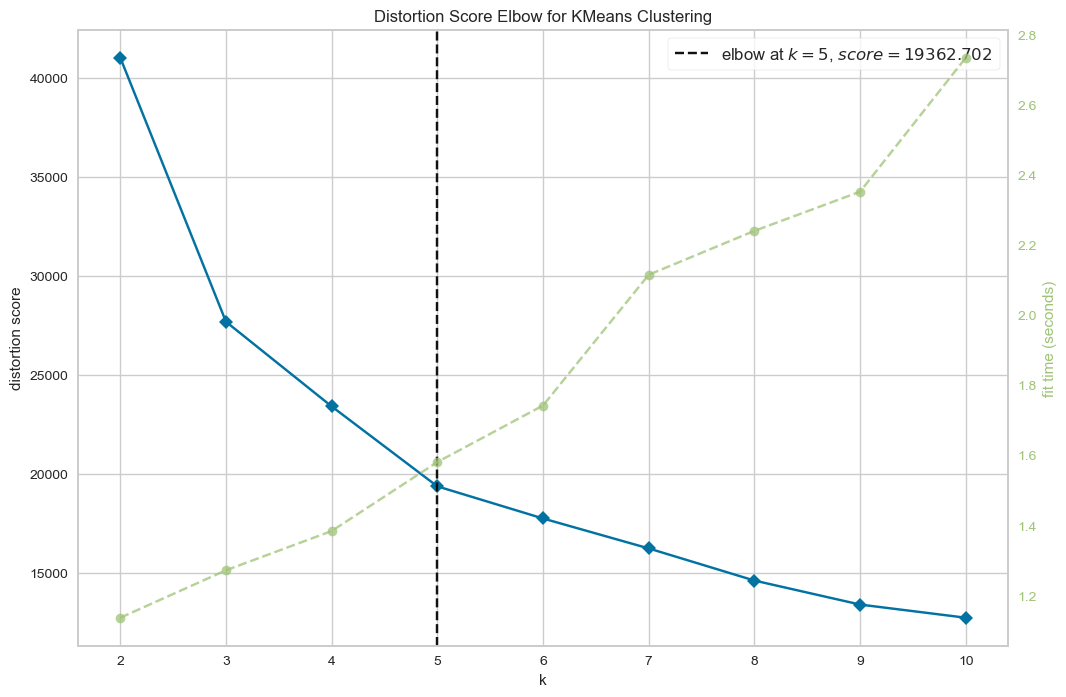

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [48]:
# Détermination du K optimal. Nous construisons un pipeline pour y inclure le preprocessing et la visualisation

X = finalData.copy()

# Méthode du coude

kmeans_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("kelbowvisualizer", KElbowVisualizer(KMeans(),K=(3,10)))])
kmeans_visualizer.fit(X)
kmeans_visualizer.named_steps['kelbowvisualizer'].show()

Nous observons qu'avec la méthode du coude basée sur le score de distortion (somme moyenne des carrés des distances aux centres), une segementation en K=5 clusters serait la meilleure option.

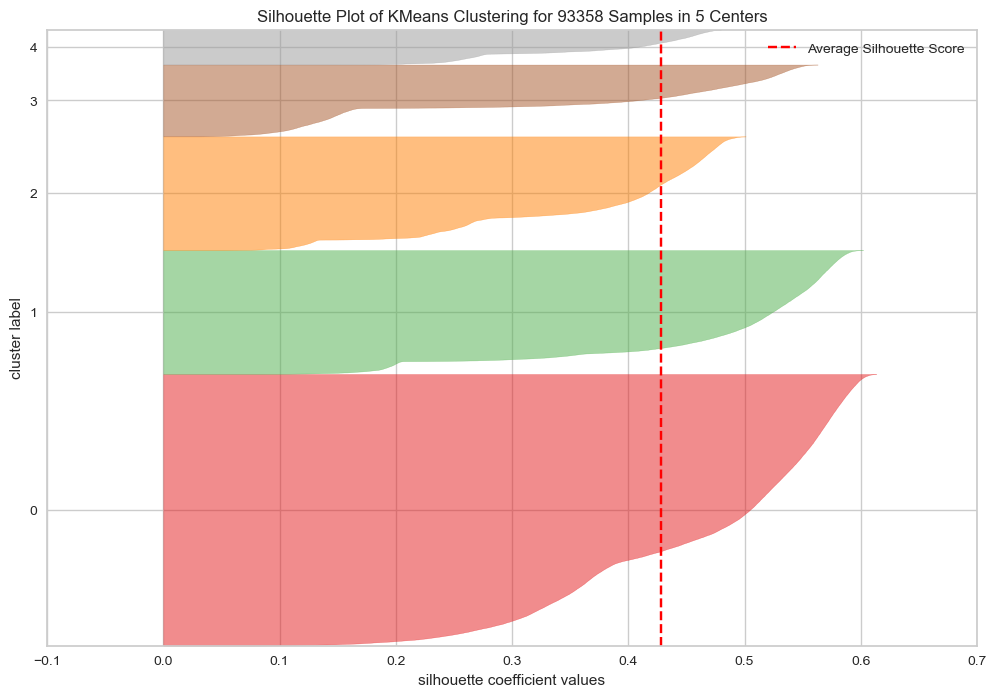

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 93358 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [49]:
# Visualisons les silhouettes et affichons le coefficient de silhouette

## le meilleur K par le coude
K = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_

## Visualisation des silhouette des différents clusters

silhouette_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("silhouettevisualizer", SilhouetteVisualizer(KMeans(K)))])
silhouette_visualizer.fit(X)
silhouette_visualizer.named_steps['silhouettevisualizer'].show()

Le score de chaque échantillon est calculé en faisant la moyenne du coefficient de silhouette (différence entre la distance moyenne intra-cluster et la distance moyenne du cluster le plus proche pour chaque échantillon), normalisée par la valeur maximale. Cela nous donne un score entre -1 et 1, qui nous permet de déterminer si la séparation est efficace ou si les points sont assignés au mauvais cluster.

Ici, les clusters sont bien répartis et les séparations sont semblent claires.

A présent, nous allons tester d'autres types de métriques pour trouver le meilleur K :

- Silouhette : rapport moyen entre la distance intra-cluster et la distance du cluster le plus proche,
- Calinski Harabasz : rapport entre la dispersion des grappes dans et entre les groupes.

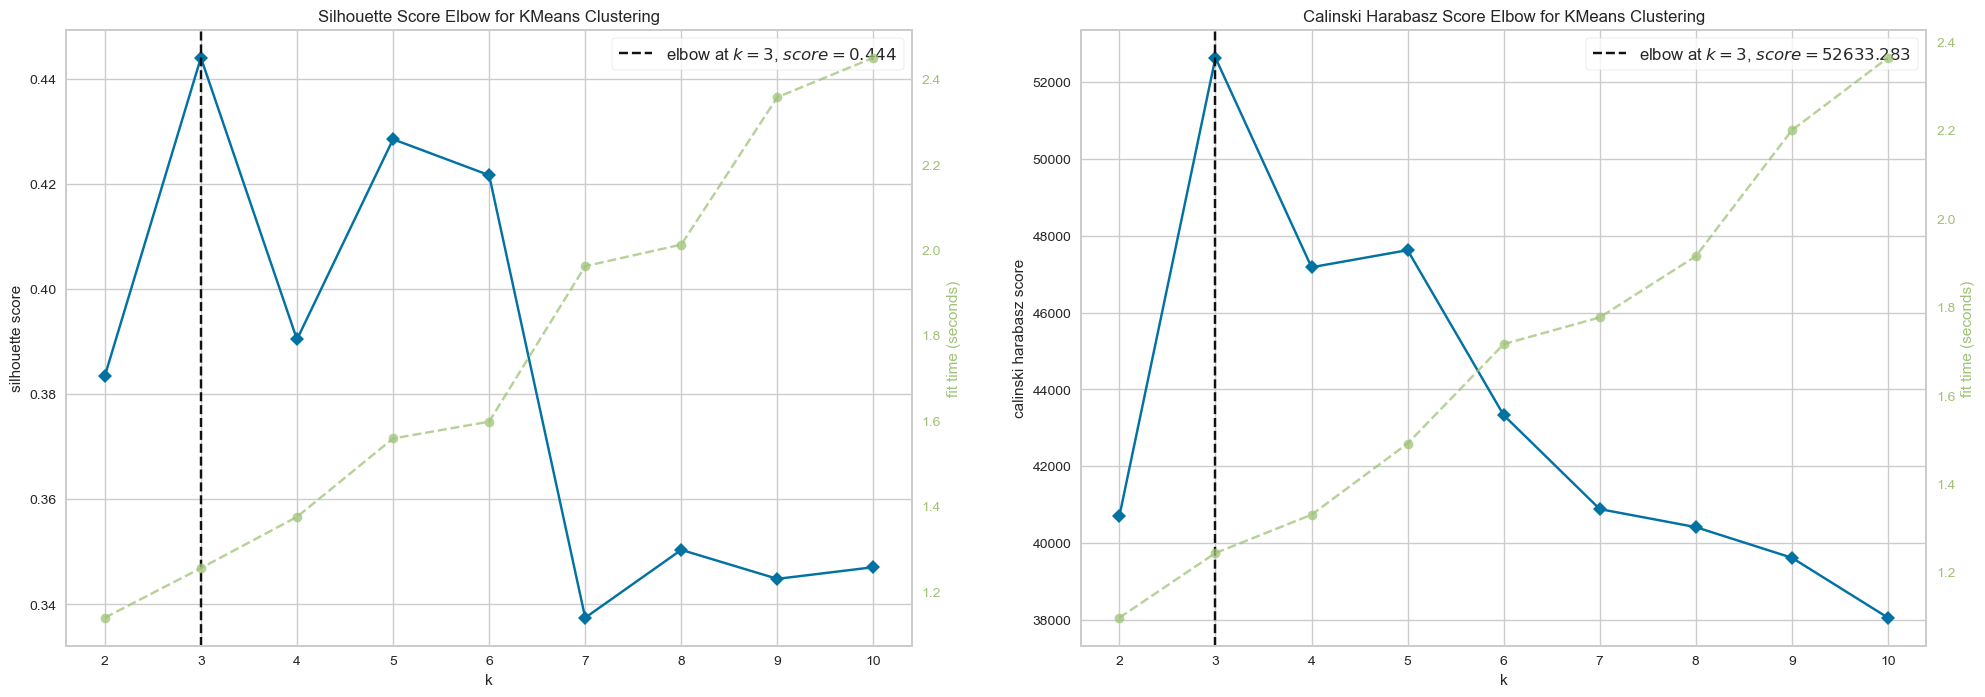

In [50]:
# Méthode du coude avec différents metrics

metrics = ["silhouette", "calinski_harabasz"]
i = 0

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(24,8))
for m in metrics:
    kmeans_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("kelbowvisualizer", KElbowVisualizer(KMeans(),
                                              K=(3,10),
                                              metric=m,
                                              ax=axes[i]))])
    kmeans_visualizer.fit(X)
    kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
    i+=1

plt.show()

Nous remarquons le score de silhouette et le score de Calinski Harabasz préconissent de retenir un K=3. En effet selon ce graphique, ce K est celui qui maximise le score de silhouette et maximise également le score Calinski Harabasz. Cependant dans la volonté d'obtenir une segmentation beaucoup plus fine comme le souhaite Olist et répondre aux besoins des équipes Customer Experience, nous retenons un K=5. Bien que pas optimal, celui-ci nous donne des scores très convenables avec un niveau d'analyse métier plus détaillé.

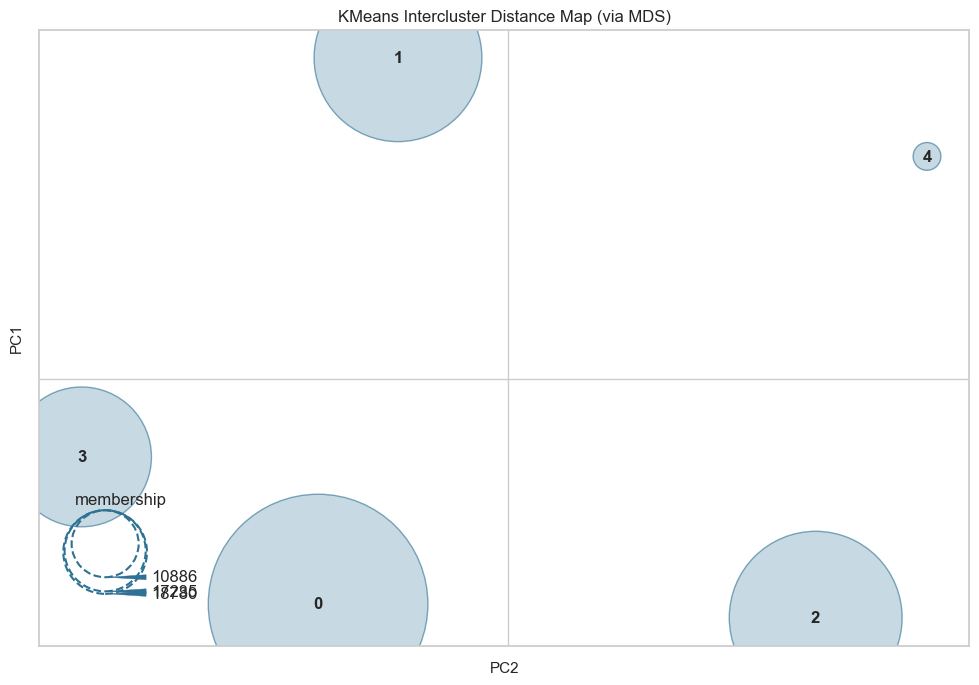

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [51]:
# Visualisation de la distance entre les cluster avec le meilleur K

distance_visualizer = Pipeline([
    ("preprocessor", preprocessor),
    ("distancevisualizer", InterclusterDistance(KMeans(K)))])
distance_visualizer.fit(X)
distance_visualizer.named_steps['distancevisualizer'].show()

Nous observons une bonne séparation des clusters sur cette projection 2D

In [52]:
# Entrainons le modèle KMeans avec le K optimal déterminer soit K=5 et affectons chaque client à son cluster.

## le pipeline KMeans avec le meilleur K

kmeans_model = Pipeline([("preprocessor", preprocessor),
                         ("kmeans", KMeans(K))])
kmeans_model.fit(X)

# Kmeans labels
kmeans_labels = kmeans_model.named_steps['kmeans'].labels_
finalData["kmeans_label"] = kmeans_labels

In [53]:
# Regroupement des clients par cluster afin d'analyser les valeurs moyennes

kmeans_clusters_means = finalData.groupby("kmeans_label").mean().reset_index()
kmeans_clusters_means

kmeans_label     recency  frequency    monetary   freight       weight  \
0             0  237.807530   1.060200  162.698344  0.300182  2167.179673   
1             1  244.983000   1.067363  136.872992  0.357293  1943.202900   
2             2  226.926624   1.081150  151.786620  0.265453  2030.575598   
3             3  239.256384   1.117858  169.049324  0.318700  2323.309679   
4             4  234.780840   1.074130  125.055307  0.302739  1929.501521   

      length     height      width  delivery_delay  carrier_delay  \
0  30.241916  16.724980  23.205057       11.577177       2.593872   
1  29.708603  15.859528  22.544369       13.796387       2.738025   
2  29.763873  16.341495  22.889961       10.622912       2.776160   
3  30.727821  17.032460  23.374056       18.303558       3.684787   
4  29.753849  15.922638  22.515000       11.357566       2.788709   

   approval_delay     score  credit_card  debit_card   voucher  small_city  
0        0.184216  4.749102          1.0    0.000000  0.000000         1.0  
1        1.208295  4.171976          0.0    0.059472  0.105251         1.0  
2        0.179508  4.154313          1.0    0.000000  0.000000         0.0  
3        0.202888  1.934595          1.0    0.000000  0.000000         1.0  
4        1.154009  4.130584          0.0    0.080783  0.126022         0.0

In [54]:
X_scaled = preprocessor.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, index=X.index, columns=X.columns)
X_scaled["kmeans_label"] = kmeans_labels
X_scaled_clusters = X_scaled.groupby("kmeans_label").mean()
X_scaled_clusters

recency  frequency  monetary   freight    weight    length  \
kmeans_label                                                                
0             0.333531   0.004300  0.020247  0.013994  0.053610  0.237162   
1             0.343595   0.004812  0.016832  0.016657  0.048069  0.231720   
2             0.318270   0.005796  0.018804  0.012375  0.050231  0.232284   
3             0.335563   0.008418  0.021087  0.014858  0.057472  0.242121   
4             0.329286   0.005295  0.015269  0.014114  0.047730  0.232182   

                height     width  delivery_delay  carrier_delay  \
kmeans_label                                                      
0             0.142961  0.153617        0.052832       0.585271   
1             0.134559  0.147718        0.063445       0.585757   
2             0.139238  0.150803        0.048268       0.585885   
3             0.145946  0.155126        0.085000       0.588945   
4             0.135171  0.147455        0.051782       0.585927   

              approval_delay     score  credit_card  debit_card   voucher  \
kmeans_label                                                                
0                   0.005964  0.937275          1.0    0.000000  0.000000   
1                   0.039116  0.792994          0.0    0.059472  0.105251   
2                   0.005811  0.788578          1.0    0.000000  0.000000   
3                   0.006568  0.233649          1.0    0.000000  0.000000   
4                   0.037359  0.782646          0.0    0.080783  0.126022   

              small_city  
kmeans_label              
0                    1.0  
1                    1.0  
2                    0.0  
3                    1.0  
4                    0.0

In [55]:
def plot_radars(data, group):

    scaler = MinMaxScaler()
    data = pd.DataFrame(scaler.fit_transform(data), 
                        index=data.index,
                        columns=data.columns).reset_index()   
    fig = go.Figure()

    for k in data[group]:
        fig.add_trace(go.Scatterpolar(
            r=data[data[group]==k].iloc[:,1:].values.reshape(-1),
            theta=data.columns[1:],
            fill='toself',
            name='Cluster '+str(k)))
        fig.update_layout(
        polar=dict(radialaxis=dict(visible=True,range=[0, 1])),
        showlegend=True,
        title={'text': "Comparaison des moyennes par variable des clusters",
            'y':0.95,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'},
        title_font_color="black",
        title_font_size=18)
    fig.show()

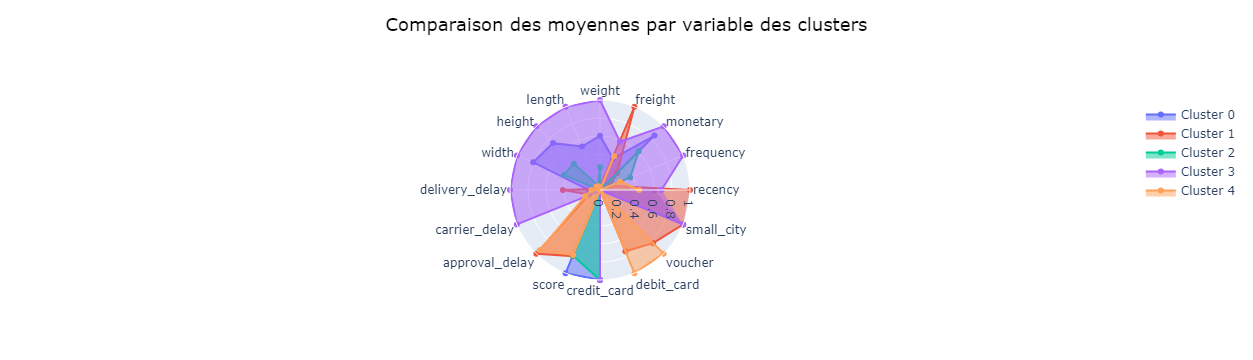

In [56]:
plot_radars(data=X_scaled_clusters,
            group="kmeans_label")

# Analyse / Interprétation des différents clusters

Nous avons en tout 5 clusters :

- Le cluster O : Ce sont les clients ayant le panier moyen le plus élévé, ils résident dans de petites villes. Ils achètent des articles volumineux, ont une bonne fréquence d'achat et paient des frais de port considérables. Leurs délais de livraison et de transport sont les plus élevés. Ils règlent par carte de crédit et sont très insatisfaits de leur expérience d'achat.

- Le cluster 1 : Ce sont les clients ayant un panier moyen élevé, résidant dans de petites villes. Ils réglent par carte de crédit et sont très satisfaits de leur expérience d'achat.

- Le cluster 2 : Ce sont les clients qui paient les frais de port les plus élevés. Leurs achats sont les plus récents et les délais d'approbation sont les plus élevés. Ils résident dans de petites villes, règlent par carte de débit ou par bons. Ils sont satisfaits de leur expérience d'achat.

- Le cluster 3 : Ce sont les clients qui ont un panier moyen faible, ils résident dans de grandes villes. Leurs achats ne sont pas fréquents. Ils règlent soit par bons ou carte de débit, ont un délai d'approbation élevé et sont satisfaits de leur expérience d'achat.

- Le cluster 4 : Ce sont les clients dont le dernier achat est le plus lointain, ils paient les frais de port les moins élevés. Leur panier moyen est assez élevé, ils résident dans de grandes villes et règlent exclusivement par carte de crédit. Ils sont satisfaits de leur expérience d'achat.

# Pouvons-nous réduire les dimensions avec la mise en place d'un ACP?

In [57]:
# ACP dans un pipeline
pca = Pipeline([("preprocessor", MinMaxScaler()),
                ("pca", PCA(svd_solver='full'))])
pca.fit(X)
X_projected = pca.transform(X)

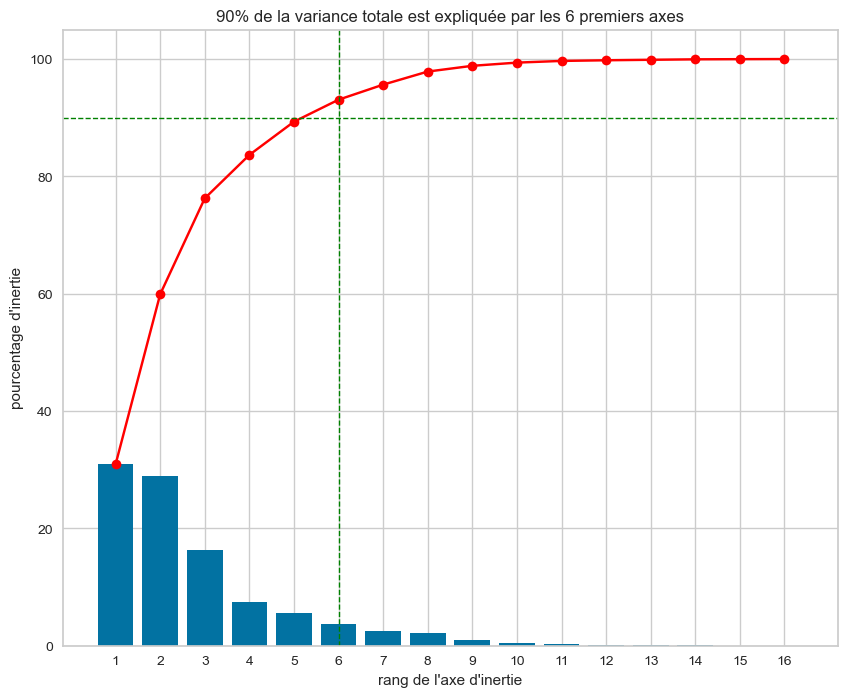

In [58]:
# Eboulis des valeurs propres

# Variance expliquée
varexpl = pca.named_steps['pca'].explained_variance_ratio_*100

# Variance cumulée
plt.figure(figsize=(10,8))
plt.bar(np.arange(len(varexpl))+1, varexpl)

cumSumVar = varexpl.cumsum()
plt.plot(np.arange(len(varexpl))+1, cumSumVar,c="red",marker='o')
plt.axhline(y=90, linestyle="--", 
            color="green",
            linewidth=1)

limit = 90
valid_idx = np.where(cumSumVar >= limit)[0]
min_plans = valid_idx[cumSumVar[valid_idx].argmin()]+1
plt.axvline(x=min_plans, linestyle="--", 
            color="green",
            linewidth=1)

plt.xlabel("rang de l'axe d'inertie")
plt.xticks(np.arange(len(varexpl))+1)
plt.ylabel("pourcentage d'inertie")
plt.title("{}% de la variance totale est expliquée"\
          " par les {} premiers axes".format(limit,
                                            min_plans))
plt.show(block=False)

In [59]:
# Cercles des corrélations

def cerle_corr(pcs, n_comp, pca, axis_ranks, 
               labels=None, label_rotation=0):
    
    fig=plt.figure(figsize=(20,n_comp*5))
    count=1
    for d1, d2 in axis_ranks:
        if d2 < n_comp:
            
            # Initialisation de la figure
            #fig.subplots_adjust(left=0.1,right=0.9,bottom=0.1,top=0.9)
            ax=plt.subplot(int(n_comp/2),2,count)
            ax.set_aspect('equal', adjustable='box') 
            
            # Détermination des limites du graphique
            ax.set_xlim(-1,1) 
            ax.set_ylim(-1,1) 

            # Affichage des flèches 
            ax.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                       pcs[d1,:],pcs[d2,:], 
                       angles='xy', scale_units='xy', scale=1, 
                       color="black", alpha=0.5)
            # Affichage des noms de variables
            for i,(x,y) in enumerate(pcs[[d1,d2]].T):
                ax.annotate(labels[i],(x,y),
                             ha='center', va='center',
                             fontsize='14',color="#17aafa", alpha=0.8) 

            # Ajout les axes 
            ax.plot([-1,1],[0,0],linewidth=1, color='grey', ls='--') 
            ax.plot([0,0],[-1,1],linewidth=1, color='grey', ls='--')

            # Ajout des cercles
            cercle = plt.Circle((0,0),1,color='#17aafa',fill=False) 
            ax.add_artist(cercle) 

            # Ajout des noms des axes, avec leur pourcentage d'inertie expliquée
            ax.set_xlabel('F{} ({}%)'.format(d1+1, 
                                          round(100*pca.explained_variance_ratio_[d1],1)))
            ax.set_ylabel('F{} ({}%)'.format(d2+1, 
                                          round(100*pca.explained_variance_ratio_[d2],1)))

            ax.set_title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            count+=1
            
    plt.suptitle("Cercles des corrélations sur les {} premiers axes".format(n_comp),
                 y=.9, color="black", fontsize=18)        
    plt.show(block=False)

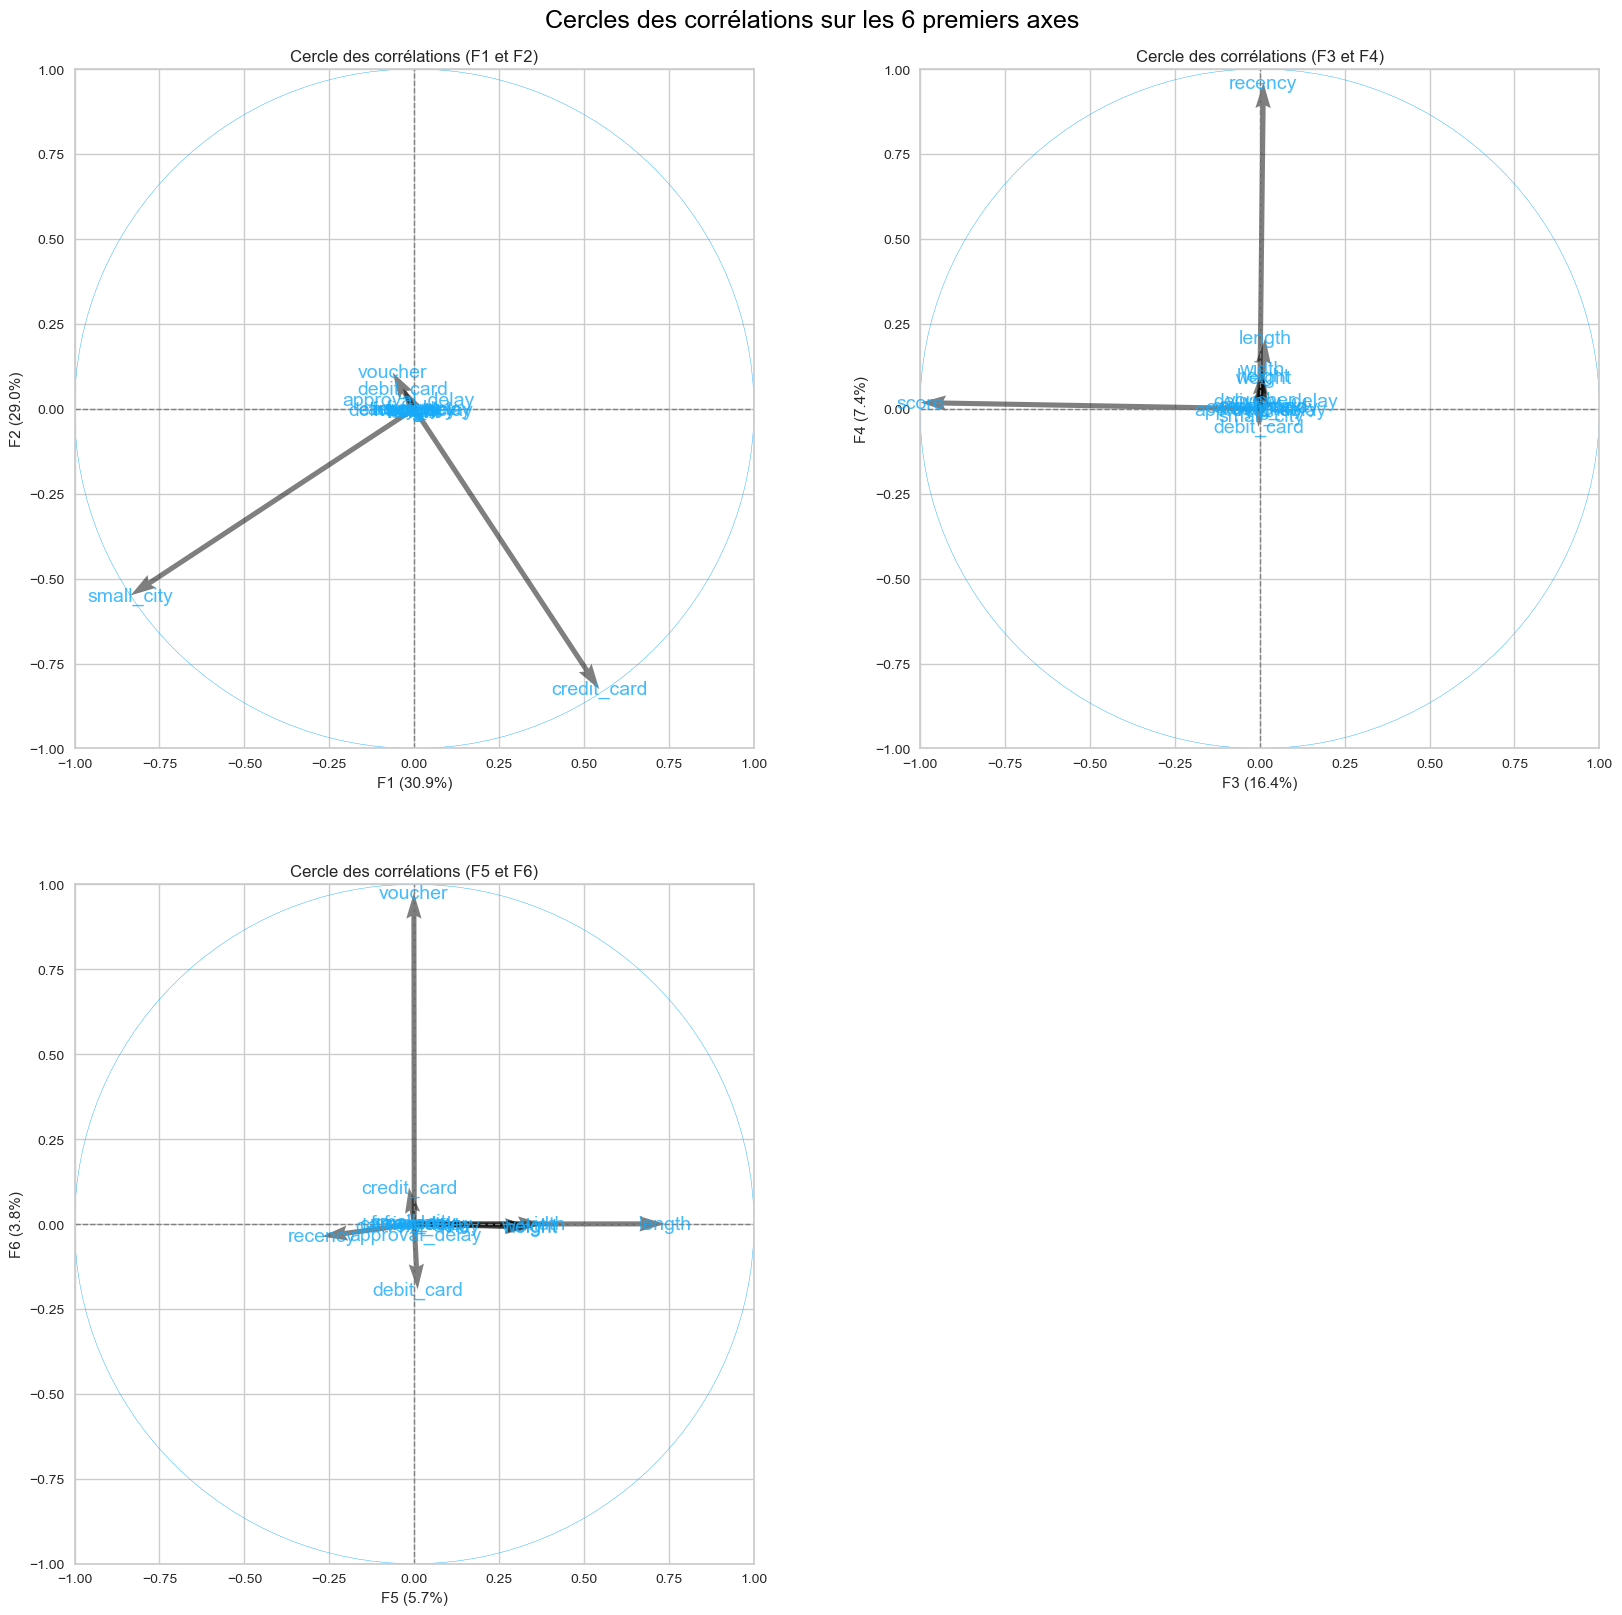

In [60]:
# Les composantes principales
pcs = pca.named_steps['pca'].components_

# Visualisation des cercles de corrélation
cerle_corr(pcs,
           6,
           pca.named_steps['pca'],
           [(0,1),(2,3),(4,5)],
           labels = np.array(X.columns))

# KMeans après réduction de dimensions

In [61]:
# Pipeline KMeans avec le meilleur K pour les résultats de l'ACP

kmeans_model_pca = Pipeline([("preprocessor", MinMaxScaler()),("kmeans", KMeans(K))])
kmeans_model_pca.fit(X_projected[:,:5])

# Kmeans labels
pca_kmeans_labels = kmeans_model_pca.named_steps['kmeans'].labels_
X_scaled["kmeans_label_pca"] = pca_kmeans_labels
X_scaled_clusters_pca = X_scaled.groupby("kmeans_label_pca").mean()
X_scaled_clusters_pca.iloc[:,:-1]

recency  frequency  monetary   freight    weight    length  \
kmeans_label_pca                                                                
0                 0.329582   0.009762  0.021453  0.014697  0.058855  0.241601   
1                 0.334653   0.004423  0.020088  0.014090  0.053696  0.237662   
2                 0.343499   0.004414  0.016647  0.016599  0.047695  0.231719   
3                 0.328636   0.004701  0.015032  0.014069  0.046264  0.229690   
4                 0.317993   0.005308  0.018503  0.012287  0.048483  0.230419   

                    height     width  delivery_delay  carrier_delay  \
kmeans_label_pca                                                      
0                 0.146997  0.154565        0.095078       0.590446   
1                 0.142978  0.153725        0.054239       0.585445   
2                 0.133921  0.147680        0.059500       0.585218   
3                 0.133682  0.146733        0.047005       0.585283   
4                 0.137793  0.149885        0.042196       0.585156   

                  approval_delay     score  credit_card  debit_card   voucher  \
kmeans_label_pca                                                                
0                       0.013133  0.048089     0.809604    0.010335  0.022006   
1                       0.005978  0.895990     1.000000    0.000000  0.000000   
2                       0.038962  0.873251     0.000000    0.060259  0.104416   
3                       0.037085  0.874204     0.000000    0.083015  0.126539   
4                       0.005728  0.900731     1.000000    0.000000  0.000000   

                  small_city  
kmeans_label_pca              
0                   0.728528  
1                   1.000000  
2                   1.000000  
3                   0.000000  
4                   0.000000

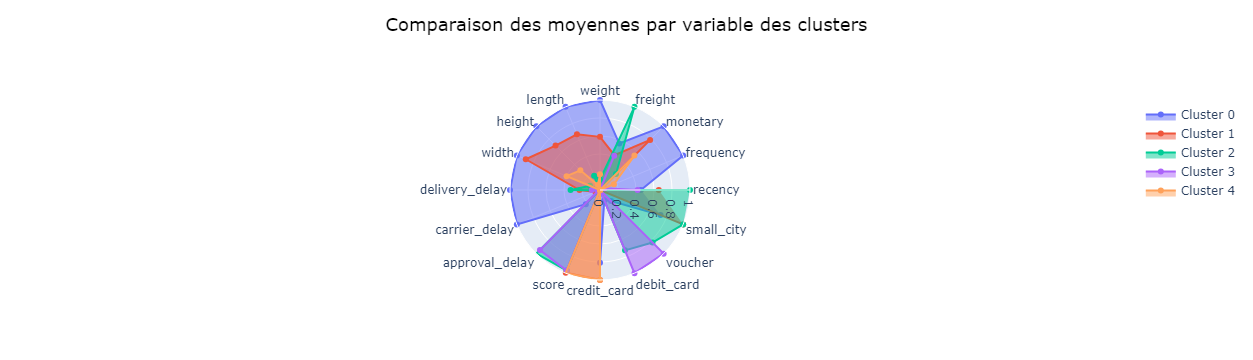

In [62]:
plot_radars(data=X_scaled_clusters_pca.iloc[:,:-1],
            group="kmeans_label_pca")

# Analyse / Interprétation des différents clusters

- Le cluster O : Ce sont les clients ayant un panier moyen élevé, résidant dans de petites villes. Ils réglent par carte de crédit et sont très satisfaits de leur expérience d'achat.

- Le cluster 1 : Ce sont les clients ayant le panier moyen le plus élévé, ils résident dans de petites villes. Ils achètent des articles volumineux, ont une très bonne fréquence d'achat et paient des frais de port considérables. Leurs délais de livraison et de transport sont les plus élevés. Ils règlent principalement par carte de crédit et sont très insatisfaits de leur expérience d'achat.

- Le cluster 2 : Ce sont les clients dont le dernier achat est le plus lointain, ils paient les frais de port les moins élevés. Leur panier moyen est assez élevé, ils résident dans de grandes villes et règlent exclusivement par carte de crédit. Ils sont très satisfaits de leur expérience d'achat.

- Le cluster 3 : Ce sont les clients qui paient les frais de port les plus élevés. Leurs achats sont les plus récents et les délais d'approbation sont les plus élevés. Ils résident dans de petites villes, règlent par carte de débit ou par bons. Ils sont satisfaits de leur expérience d'achat.

- Le cluster 4 : Ce sont les clients qui ont un panier moyen le plus faible, ils résident dans de grandes villes. Leurs achats ne sont pas fréquents. Ils règlent soit par bons ou carte de débit, ont un délai d'approbation élevé et sont satisfaits de leur expérience d'achat.

In [63]:
# Evaluation de la qualité du clustering

def clustering_eval(preprocessor, model, data, metric, elbow=True, mds=False, KBest=None):
    
    if((elbow==True) & (mds==True)):
        ncols=3
    elif((elbow==False) | (mds==False)):
        ncols=2
    else:
        ncols=1
        
    fig, axes = plt.subplots(nrows=1, ncols=ncols, sharex=False, sharey=False, figsize=(24,8))
    
    ax=0
    if(elbow==True):
        # Visualisation du coude
        kmeans_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("kelbowvisualizer", KElbowVisualizer(model,K=(4,12), metric=metric, ax=axes[ax]))])
        kmeans_visualizer.fit(data)
        KBest = kmeans_visualizer.named_steps['kelbowvisualizer'].elbow_value_
        kmeans_visualizer.named_steps['kelbowvisualizer'].finalize()
        ax+=1
    
    # Le meilleur K
    K = KBest
    model.set_params(n_clusters=K)

    # Visualisation des silhouettes
    silhouette_visualizer = Pipeline([
        ("preprocessor", preprocessor),
        ("silhouettevisualizer", SilhouetteVisualizer(model, ax=axes[ax]))])
    silhouette_visualizer.fit(data)
    silhouette_visualizer.named_steps['silhouettevisualizer'].finalize()
    ax+=1
    
    # La carte des distance inter-groupe avec le meilleur K
    if(mds==True):
        distance_visualizer = Pipeline([
            ("preprocessor", preprocessor),
            ("distancevisualizer", InterclusterDistance(model, ax=axes[ax]))])
        distance_visualizer.fit(data)
        distance_visualizer.named_steps['distancevisualizer'].finalize()
    
    return K
    plt.show()

5

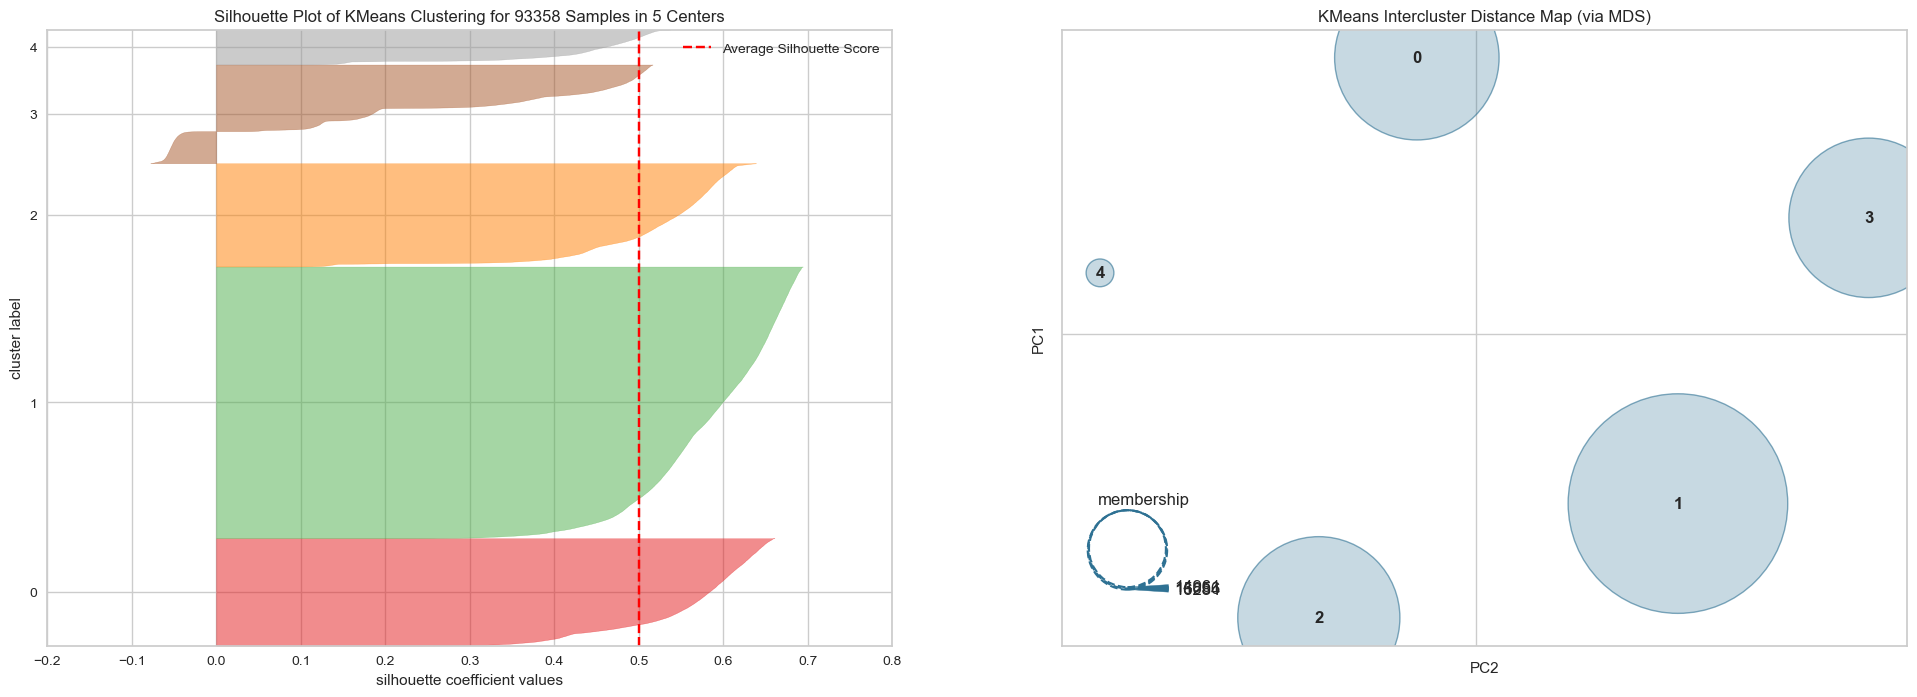

In [64]:
clustering_eval(preprocessor=MinMaxScaler(), 
                model=KMeans(), 
                data=X_projected[:,:5], 
                metric="distortion",
                elbow=False,
                mds=True,
                KBest=K)

# Analyse de la stabilité à l'initialisation KMeans

In [65]:
labels = pca_kmeans_labels
pca_data = X_projected[:,:5]

In [66]:
def bench_k_means(model, name, data, labels):
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), model).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[1].inertia_]
    
    # Teste de différents métriques sur les étiquettes prédites
    clustering_metrics = [
        homogeneity_score,
        adjusted_rand_score,
        adjusted_mutual_info_score]
    results += [m(labels, estimator[1].labels_) for m in clustering_metrics]
    
    # Affichage des résultats
    formatter_result = ("{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
                        "\t{:.3f}\t{:.3f}")
    print(formatter_result.format(*results))

In [67]:
print("Scores de stabilité à l'initialisation")
print(55 * '_')
print('Iteration\tFitTime\tInertia\tHomo\tARI\tAMI')
print(55 * '_')

for i in range(10):
    imodel = KMeans(n_clusters=K, n_init=1, init="k-means++")
    bench_k_means(model = imodel, name="Iter "+str(i), 
                  data=pca_data, labels=labels)

print(55 * '_')

Scores de stabilité à l'initialisation
_______________________________________________________
Iteration	FitTime	Inertia	Homo	ARI	AMI
_______________________________________________________
Iter 0   	0.236s	9043	0.831	0.828	0.823
Iter 1   	0.218s	9171	0.895	0.691	0.836
Iter 2   	0.222s	8461	0.986	0.995	0.984
Iter 3   	0.228s	9171	0.895	0.691	0.836
Iter 4   	0.204s	8477	0.954	0.982	0.952
Iter 5   	0.271s	9098	0.895	0.661	0.829
Iter 6   	0.217s	9200	0.893	0.689	0.835
Iter 7   	0.243s	9128	0.893	0.660	0.829
Iter 8   	0.229s	9128	0.893	0.659	0.829
Iter 9   	0.238s	8859	0.808	0.814	0.792
_______________________________________________________
